<a href="https://colab.research.google.com/github/Claudio-Ferriz/c18-64-t-data-bi/blob/main/NO_COUNTRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##instalaciones
* falta conectar github con esta notebook

In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
#falta depurar librerias
import requests
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import os
import glob
from unidecode import unidecode
import folium
from ipywidgets import interact, Dropdown
from geopy.geocoders import Nominatim
import re
import pandas as pd
import numpy as np
from folium.plugins import HeatMap
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

## elección datos tablas delito y ventas

In [ ]:
filas_elegidas_delito = ['Robo automotor', 'Hurto automotor',"Robo total",'Femicidios','Lesiones Dolosas']

In [ ]:
#COMUNA15
filas_elegidas_delito = ['Robo total', "Hurto total",'Muertes por siniestros viales', 'Robo automotor','Hurto automotor', 'Lesiones Dolosas', 'Homicidios dolosos']

## Tabla delitos y tabla ventas
* si se recién se descarga los datos totales, el class del delito tarda máximo 1 minutos en cargar. Luego de eso dura max 5 segundos
* el código se va a modificar según las visualizaciones necesarias
* datos superficie por barrio https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2016/04/DT011123.pdf

In [ ]:
class DelitosAnual:
    def __init__(self, year):
        if not isinstance(year, int) or year < 2016 or year > 2022:
            raise ValueError("El año debe estar entre 2016 y 2022.")
        self.year = year

    def csv_raw(self,abrir=True): #iteración descargar todo, no continuar sino
        link = f'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{self.year}.csv'
        ruta_archivo = f'/content/delitos_{self.year}.csv'
        if not os.path.exists(ruta_archivo):
          with open(ruta_archivo, 'wb') as file:
              file.write(requests.get(link).content)
        if abrir:
          return pd.read_csv(ruta_archivo)

    def tabla_general(self):
        csv = self.csv_raw()
        columnas_necesarias = ["mes",	"subtipo",	"barrio",	"latitud",	"longitud",	"cantidad"]
        filas_necesarias = filas_elegidas_delito
        csv =csv.dropna()
        csv_filas = csv[csv['subtipo'].isin(filas_necesarias)]
        csv_filas = csv_filas[~((csv_filas['uso_arma'] == 'NO') & (csv_filas['subtipo'] == 'Robo total'))]
        csv_colums = csv_filas[columnas_necesarias]
        tabla_general = csv_colums.rename(columns={'subtipo': 'delito'})
        tabla_general['delito'] = tabla_general['delito'].replace('Robo total', 'Robo Armado')

        return tabla_general

    def tabla_por_delito(self):
        csv = self.tabla_general()
        csv = csv.drop(["latitud", "longitud"], axis =1) ####
        meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
        trimestres = {1: f'{self.year}.1', 2: f'{self.year}.2', 3: f'{self.year}.3', 4: f'{self.year}.4'}
        mes_a_trimestre = {mes: trimestres[(i // 3) + 1] for i, mes in enumerate(meses)}
        csv['trimestre'] = csv['mes'].map(mes_a_trimestre)
        tabla_por_delito = csv.groupby(['trimestre', 'delito', 'barrio']).agg({'cantidad': 'sum'}).reset_index()
        tabla_por_delito = tabla_por_delito.pivot_table(index=["barrio","trimestre"],columns='delito', values='cantidad', fill_value=0).reset_index()
        tabla_por_delito.columns.name = None
        return tabla_por_delito

    def tabla_por_trimestre(self):
        csv = self.tabla_por_delito()
        columnas_int = csv.select_dtypes(include=['int'])
        suma_columnas_int = columnas_int.sum(axis=1)
        csv = csv.drop(columnas_int.columns, axis=1)
        csv['delito total'] = suma_columnas_int
        tabla_por_trimestre = csv.pivot(index="barrio",columns='trimestre', values='delito total').reset_index()
        tabla_por_trimestre.columns.name = None
        return tabla_por_trimestre

    def tabla_por_trimestre_sup(self, redondear=True):
        csv = self.tabla_por_trimestre()
        trimestres = csv.columns[-4:]
        csv[trimestres] = csv[trimestres].astype(float)
        barrios_superficie = [2.1, 4, 4.3, 7.9, 7.9, 5, 2.6, 6.8, 3.1, 1.2, 2.2, 2.1, 8.5, 2.3, 4.3, 7.3, 2.2, 2.6, 4.9, 4.3, 15.7, 4.7, 3.8, 1.3, 3.7, 2.2, 5, 6.1, 4.5, 5.5, 2, 2.2, 1.2, 2.4, 1.4, 3.6, 3.3, 6.4, 2.1,9.2, 2.5, 1.8, 3.3, 1.3, 4.2, 2.1, 8.6, 5.4]
        for i, row in csv.iterrows():
          csv.loc[i, trimestres] = row[trimestres] / barrios_superficie[i]
        if redondear:
          csv = csv.applymap(self.redondeo_numeros)
        return csv

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x

    def descargar_todos_los_archivos(self):
        archivos_existentes = glob.glob('/content/delitos_*.csv')
        if len(archivos_existentes) < 7:
            for year in range(2016, 2023):
                self.year = year
                self.csv_raw(abrir=False)

    def combinar_todos_los_archivos(self, redondear=False):
        self.descargar_todos_los_archivos()
        year = 2016
        self.year = year
        tabla_primera = self.tabla_por_trimestre_sup(redondear=redondear)
        tabla_primera["barrio"] = tabla_primera["barrio"].str.title()
        tabla_primera["barrio"] =tabla_primera["barrio"].apply(unidecode)
        tabla_primera = tabla_primera.rename(columns={'barrio': 'Barrio'})
        all_data = [tabla_primera]
        for year in range(2017, 2023):
            self.year = year
            all_data.append(self.tabla_por_trimestre_sup(redondear=redondear).iloc[:, 1:])
        combined_data = pd.concat(all_data, axis=1)
        combined_data.set_index("Barrio", inplace=True)
        return combined_data

year_delito = DelitosAnual(2016)
csv_crudo = year_delito.csv_raw()
tabla_con_ubicaciones = year_delito.tabla_general()
tabla_por_delito = year_delito.tabla_por_delito()
tabla_por_trimestre = year_delito.tabla_por_trimestre()
tabla_por_trimestre_sup_redondeado = year_delito.tabla_por_trimestre_sup()
tabla_delitos = year_delito.combinar_todos_los_archivos()

In [ ]:
class ETLDeptoVentas:
    def __init__(self):
        self.tabla = self.xlsx_raw()

    def xlsx_raw(self):
        link = 'https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2023/12/MI_DVP_AX04.xlsx'
        ruta_archivo = '/content/MI_DVP_AX04.xlsx'
        if not os.path.exists(ruta_archivo):
            with open(ruta_archivo, 'wb') as file:
                file.write(requests.get(link).content)
        return pd.read_excel(ruta_archivo)

    def notas(self):
      for element in self.tabla.iloc[53:, 0]:
        print(element)

    def tabla_2016_2024(self, redondear=True):
      tabla_sin_NaN = self.tabla.dropna(thresh=len(self.tabla.columns)-4).replace({'///': 0})
      tabla_barrios = tabla_sin_NaN.drop(tabla_sin_NaN.columns[1], axis=1).drop(2)
      def transformacion_1():
        veces_repetidas = 0
        for columna in tabla_barrios.columns:
          if '1er. trim.' in tabla_barrios[columna].values:
            veces_repetidas += 1
            if veces_repetidas == 10:
              return tabla_barrios.columns.get_loc(columna)

      columnas_a_eliminar = tabla_barrios.columns[1:transformacion_1()]
      tabla_barrios = tabla_barrios.drop(columns=columnas_a_eliminar).drop(1)

      def transformacion_2():
        barrio = ['Barrio']
        current_year = 2016
        count_year = 0
        for i in range(1, len(tabla_barrios.columns)):
          if (i - 1) % 4 == 0 and i > 1:
            current_year += 1
            count_year = 0
          count_year += 1
          if count_year > 4:
            count_year = 1
          barrio.append(str(current_year) + '.' + str(count_year))
        return barrio

      tabla_barrios.columns = transformacion_2()
      barrios_informales = tabla_barrios[(tabla_barrios == 0.00).sum(axis=1) >= 22]
      tabla_barrios = tabla_barrios[~tabla_barrios["Barrio"].isin(barrios_informales.iloc[:, 0].unique())]
      tabla_barrios.reset_index(drop=True, inplace=True)
      tabla_barrios["Barrio"] =tabla_barrios["Barrio"].apply(unidecode)
      tabla_barrios["Barrio"] = tabla_barrios["Barrio"].str.title()
      tabla_barrios.iloc[tabla_barrios[tabla_barrios["Barrio"] == 'La Paternal'].index, tabla_barrios.columns.get_loc("Barrio")] = 'Paternal'
      tabla_barrios.iloc[tabla_barrios[tabla_barrios["Barrio"] == 'Montserrat'].index, tabla_barrios.columns.get_loc("Barrio")] = 'Monserrat'
      tabla_barrios = tabla_barrios.sort_values(by='Barrio')
      tabla_barrios.set_index("Barrio", inplace=True)

      if redondear:
        tabla_barrios = tabla_barrios.applymap(self.redondeo_numeros)
      return tabla_barrios

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x
tabla_hasta_2024 = ETLDeptoVentas().tabla_2016_2024(redondear=False)
notas_tabla1 = ETLDeptoVentas().notas()
tabla_ventas = tabla_hasta_2024.iloc[:, :ETLDeptoVentas().tabla_2016_2024(redondear=False).columns.get_loc('2022.4')+1]

Nota: solo se muestran valores para los barrios que cumplen con la cantidad mínima de unidades ofertadas requerida en cada caso. 
Hasta 2014 inclusive la información corresponde al primer mes del trimestre.
Los datos presentados pueden diferir de los publicados anteriormente debido a la implementación de cambios metodológicos en el cálculo del precio por metro cuadrado.
La información anterior a 2010 se encuentra en revisión.
Fuente: Dirección General de Estadística y Censos (Ministerio de Hacienda y Finanzas GCBA) sobre la base de datos del sistema Buscainmueble (hasta julio 2011), Adinco (entre octubre 2011 y abril 2015) y Argenprop (desde julio 2015).


## descargar tablas

In [ ]:
#descargar archivo en carpeta google colab
if os.path.exists('/content/tabla_delitos.csv'):
    os.remove('/content/tabla_delitos.csv')
tabla_delitos.to_csv('/content/tabla_delitos.csv', index=True)

In [ ]:
#descargar archivo en carpeta google colab
if os.path.exists('/content/tabla_venta.csv'):
    os.remove('/content/tabla_venta.csv')
tabla_hasta_2024.to_csv('/content/tabla_venta.csv', index=True)

## mapas
falta trabajar con la libreria pyinkscape para tener los dos mapas interactivos con colores. Por ahora se tiene el código para el mapa interactivo de ubicaciones


In [ ]:
class Delitos_Mapa_puntos:
    def __init__(self):
        self.years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
        self.trimestres = ["primer trimestre", "segundo trimestre", "tercer trimestre", "cuarto trimestre"]
        self.comunas = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15., "Todas"]
        self.delitos = filas_elegidas_delito + ['Todos']
        self.colores_delitos = {
            'Hurto automotor': 'blue',
            'Robo automotor': 'green',
            'Robo Armado': 'red',
            'Homicidios dolosos': 'black',
            'Amenazas': 'orange',
            'Lesiones Dolosas': 'purple'
        }
        self.geolocator = Nominatim(user_agent="myGeocoder")
    def descargar_todos_los_archivos(self):
        archivos_existentes = glob.glob('delitos_*.csv')
        if len(archivos_existentes) < 7:
            for year in range(2016, 2023):
              ruta_archivo = f'delitos_{year}.csv'
              if not os.path.exists(ruta_archivo):
                with open(ruta_archivo, 'wb') as file:
                    link = f'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{year}.csv'
                    file.write(requests.get(link).content)

    def ver_archivo(self, year):
        ruta_archivo = f'delitos_{year}.csv'
        return pd.read_csv(ruta_archivo)

    def tabla_delito_ubicacion(self, year):
        csv = self.ver_archivo(year)
        columnas_necesarias = ["subtipo", "mes", "comuna", "latitud", "longitud"]
        filas_necesarias = ['Hurto automotor', 'Robo automotor', 'Robo total', 'Homicidios dolosos', 'Amenazas', 'Lesiones Dolosas']
        csv = csv.dropna()
        csv = csv[csv['subtipo'].isin(filas_necesarias)]
        csv = csv[~((csv['uso_arma'] == 'NO') & (csv['subtipo'] == 'Robo total'))]
        csv = csv[columnas_necesarias]
        tabla = csv.rename(columns={'subtipo': 'delito'})
        tabla['delito'] = tabla['delito'].replace('Robo total', 'Robo Armado')
        meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
        tabla['mes'] = pd.Categorical(tabla['mes'], categories=meses, ordered=True)
        tabla = tabla.sort_values(by='mes')
        tabla.reset_index(drop=True, inplace=True)
        trimestres = {1: "primer trimestre", 2: "segundo trimestre", 3: "tercer trimestre", 4: "cuarto trimestre"}
        mes_a_trimestre = {mes: trimestres[(i // 3) + 1] for i, mes in enumerate(meses)}
        tabla['trimestre'] = tabla['mes'].map(mes_a_trimestre)
        tabla = tabla.drop(columns=['mes'])
        tabla = tabla.sort_values(by='comuna', ascending=True)
        return tabla

    def generar_mapa_interactivo(self):
        @interact(year=Dropdown(options=self.years, description="Año"),
                  trimestre=Dropdown(options=self.trimestres, description="Trimestre"),
                  delito=Dropdown(options=self.delitos, description="Tipo de Delito", value='Todos'),
                  comuna=Dropdown(options=self.comunas, description="Comuna", value='Todas'))
        def mostrar_mapa(year, trimestre, delito, comuna):
            tabla_delitos = self.tabla_delito_ubicacion(year)
            tabla_delitos = tabla_delitos[tabla_delitos['trimestre'] == trimestre]
            if comuna != 'Todas':
                tabla_delitos = tabla_delitos[tabla_delitos['comuna'] == comuna]

            mapa = folium.Map(location=[-34.61, -58.44], zoom_start=12)

            if delito == 'Todos':
                for tipo_delito, color in self.colores_delitos.items():
                    delitos_tipo = tabla_delitos[tabla_delitos['delito'] == tipo_delito]
                    self.agregar_marcadores(mapa, delitos_tipo, color)
            else:
                delitos_tipo = tabla_delitos[tabla_delitos['delito'] == delito]
                color = self.colores_delitos[delito]
                self.agregar_marcadores(mapa, delitos_tipo, color)

            display(mapa)

    def agregar_marcadores(self, mapa, datos, color):
        for index, row in datos.iterrows():
            folium.CircleMarker(location=[row['latitud'], row['longitud']], radius=1, color=color, fill=True, fill_color=color).add_to(mapa)

Delitos_Mapa_puntos().generar_mapa_interactivo()
#columna a int

interactive(children=(Dropdown(description='Año', options=(2016, 2017, 2018, 2019, 2020, 2021, 2022), value=20…

## normalización y correlación

In [ ]:
def delitos(tabla):
    # Función para escalar los valores de cada columna
    def escalar_columna(col):
        non_zero_mask = col != 0
        non_zero_values = col[non_zero_mask]
        if len(non_zero_values) > 1:
            scaled_values = (non_zero_values.rank(ascending=False, method='min') - 1) / (len(non_zero_values) - 1) * 44 + 1
            col[non_zero_mask] = scaled_values.round(3)  # Redondear a tres cifras significativas
        col[non_zero_mask] = col[non_zero_mask].astype(float)
        col[~non_zero_mask] = 0
        return col

    # Aplicar la función a cada columna
    tabla_escalada = tabla.apply(escalar_columna)
    return tabla_escalada
delitos = delitos(tabla_delitos)


In [ ]:
def ventAs(tabla):
    # Función para escalar los valores de cada columna
    def escalar_columna(col):
        non_zero_mask = col != 0
        non_zero_values = col[non_zero_mask]
        if len(non_zero_values) > 1:
            scaled_values = (non_zero_values.rank(method='min') - 1) / (len(non_zero_values) - 1) * 44 + 1
            col[non_zero_mask] = scaled_values.round(3)  # Redondear a dos cifras significativas
        col[non_zero_mask] = col[non_zero_mask].astype(float)
        col[~non_zero_mask] = 0
        return col

    # Aplicar la función a cada columna
    tabla_escalada = tabla.apply(escalar_columna)
    return tabla_escalada

# Aplicar la transformación a la tabla
ventas = ventAs(tabla_ventas)


In [ ]:
print(delitos.columns.tolist() == ventas.columns.tolist())

def borrar_indices_no_coincidentes(tabla1, tabla2):
    if any(idx not in tabla2.index for idx in tabla1.index) or any(idx not in tabla1.index for idx in tabla2.index):
        indices_comunes = tabla1.index.intersection(tabla2.index)
        tabla1_filtrada = tabla1.loc[indices_comunes]
        tabla2_filtrada = tabla2.loc[indices_comunes]
        return tabla1_filtrada, tabla2_filtrada
    else:
        print("Los índices coinciden entre ambas tablas.")
        return tabla1, tabla2
delitos, ventas = borrar_indices_no_coincidentes(delitos, ventas)


True


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def visualizar_correlacion_serie_temporal(tabla1, tabla2):
    # Calcular la media de los datos de todos los barrios
    delitos_media = tabla1.mean(axis=0)
    ventas_media = tabla2.mean(axis=0)

    # Crear una instancia del MinMaxScaler
    scaler = MinMaxScaler()

    # Normalizar los datos de la media de ambos conjuntos de datos
    delitos_media_norm = scaler.fit_transform(delitos_media.values.reshape(-1, 1)).flatten()
    ventas_media_norm = scaler.fit_transform(ventas_media.values.reshape(-1, 1)).flatten()

    # Crear la figura y los ejes
    plt.figure(figsize=(12, 6))

    # Graficar las series de tiempo normalizadas de los delitos y las ventas
    sns.lineplot(x=tabla1.columns, y=delitos_media_norm, color='orange', label='Delitos seleccionados')
    sns.lineplot(x=tabla2.columns, y=ventas_media_norm, color='blue', label='Precios de inmuebles promedio')

    # Personalizar el gráfico
    plt.xlabel('CABA')
    plt.ylabel('Valor Normalizado')
    plt.title('Correlación disminución de delitos seleccionados y aumento promedio de precios del inmueble, y viceversa')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

## visualización correlación para ir ajustando datos
* Falta debatir, para aumentar la correlación:
  * si borrar barrios informales como Villa Riachuelo
  * elegir que delitos van o no

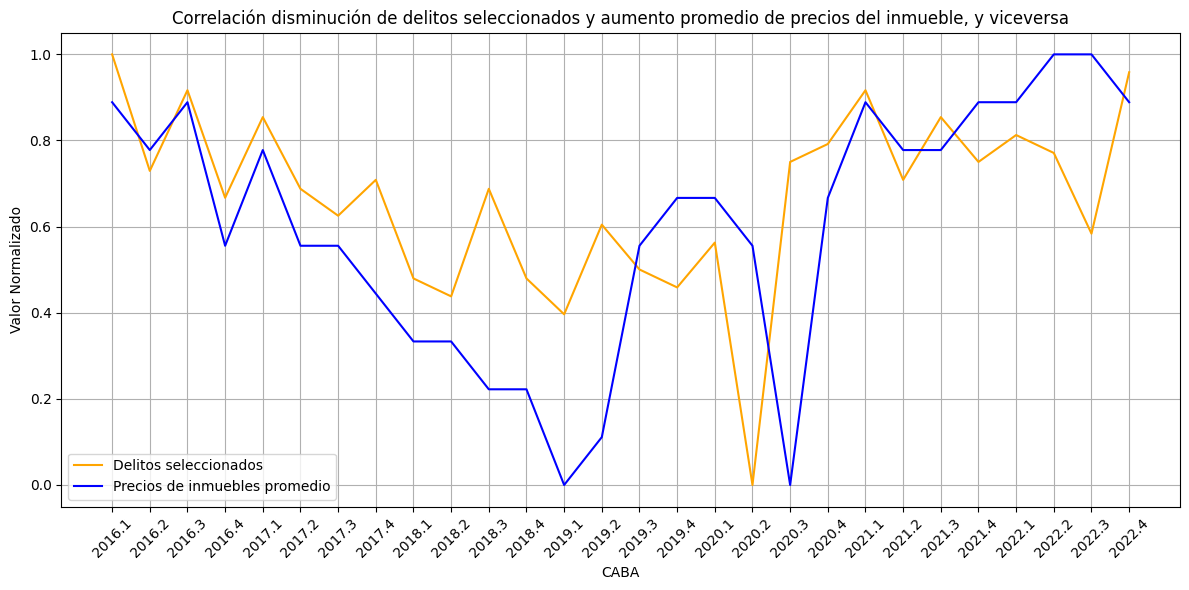

In [ ]:
visualizar_correlacion_serie_temporal(delitos, ventas)
#opción boton por barrio, no mencionar delitos elegidos

In [ ]:
pd.read_csv("/content/delitos_2016.csv")["subtipo"].unique()

array(['Robo total', 'Robo automotor', 'Hurto automotor', 'Hurto total',
       'Lesiones por siniestros viales', 'Homicidios dolosos',
       'Femicidios', 'Amenazas', 'Lesiones Dolosas',
       'Muertes por siniestros viales'], dtype=object)

## Regresión lineal

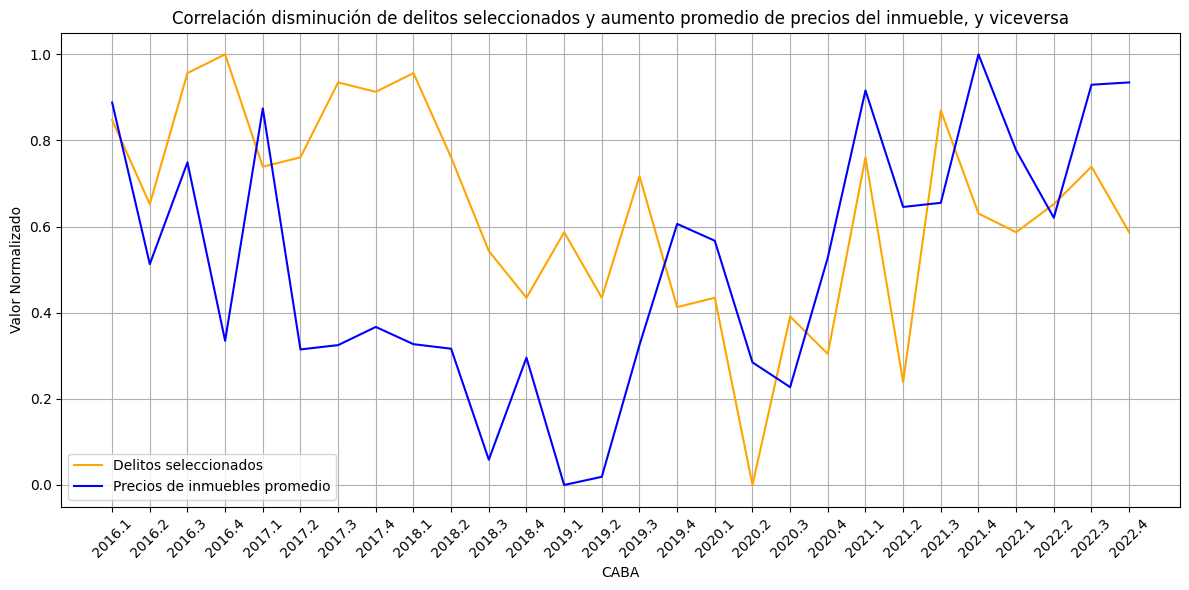

In [ ]:
barrios_deseados = ["Agronomia", "Chacarita", "Paternal", "Parque Chas", "Villa Crespo", "Villa Ortuzar"]

# Encontrar la posici
def columna_15(tabla):
  comuna15 = tabla.reset_index().rename(columns={'index': 'Barrio'})
  comuna15 = comuna15[comuna15['Barrio'].isin(barrios_deseados)]
  comuna15 = comuna15.set_index('Barrio')
  return comuna15

ventas15 = columna_15(ventas)
delitos15 = columna_15(delitos)
visualizar_correlacion_serie_temporal(delitos15, ventas15)

In [ ]:
delitos = delitos15  # Ajusta el path a tu archivo
ventas = ventas15    # Ajusta el path a tu archivo

In [ ]:
ventas_2023_2024 = pd.read_csv('tabla_venta.csv')
ventas_2023_2024 = ventAs(ventas_2023_2024)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datos de delitos y ventas

ventas_2023_2024 = ventas_2023_2024.iloc[:, -8:]

delitos_media = delitos.mean(axis=0)
ventas_media = ventas.mean(axis=0)
scaler = MinMaxScaler()
delitos_scaled = scaler.fit_transform(delitos_media.values.reshape(-1, 1)).flatten()
ventas_scaled = scaler.fit_transform(ventas_media.values.reshape(-1, 1)).flatten()

# Crear DataFrame escalado
data = pd.DataFrame({
    'delitos': delitos_scaled,
    'ventas': ventas_scaled
})

# Separar las variables independientes (X) y la variable dependiente (y)
X = data['delitos'].values.reshape(-1, 1)
y = data['ventas'].values

# Entrenar el mejor modelo: Regresión Lineal
best_model = LinearRegression()
best_model.fit(X, y)

# Asumimos que tienes los datos de delitos para 2023 y 2024 en delitos.csv
delitos_2023_2024 = delitos.iloc[-2:]  # Últimos dos trimestres (2023 y 2024)
delitos_2023_2024_scaled = scaler.transform(delitos_2023_2024.mean(axis=0).values.reshape(-1, 1)).flatten()

# Predecir para 2023 y 2024
ventas_pred = best_model.predict(delitos_2023_2024_scaled.reshape(-1, 1))

# Desescalar las predicciones
ventas_pred_descaled = scaler.inverse_transform(ventas_pred.reshape(-1, 1)).flatten()

# Crear índices para los trimestres de 2023 y 2024
trimestres_2023_2024 = ['2023.1', '2023.2', '2023.3', '2023.4', '2024.1', '2024.2', '2024.3', '2024.4']


# Gráfico de barras para mostrar las predicciones
plt.figure(figsize=(10, 6))
plt.bar(predicciones_df['Trimestre'], predicciones_df['Ventas Predichas'], color='blue', alpha=0.7)
plt.xlabel('Trimestre')
plt.ylabel('Ventas Predichas')
plt.title('Predicción de Ventas de Viviendas para 2023-2024')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'predicciones_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Suponiendo que tienes los datos de delitos y ventas cargados en `delitos` y `ventas` respectivamente

# Calcular la media por trimestre
delitos_media = delitos.mean(axis=0)
ventas_media = ventas.mean(axis=0)

# Escalar los datos
scaler = MinMaxScaler()
delitos_scaled = scaler.fit_transform(delitos_media.values.reshape(-1, 1)).flatten()
ventas_scaled = scaler.fit_transform(ventas_media.values.reshape(-1, 1)).flatten()

# Crear DataFrame escalado
data = pd.DataFrame({
    'delitos': delitos_scaled,
    'ventas': ventas_scaled
})

# Separar las variables independientes (X) y la variable dependiente (y)
X = data['delitos'].values.reshape(-1, 1)
y = data['ventas'].values

# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predecir para 2023 y 2024
# Supongamos que tienes los datos de delitos para 2023 y 2024 en `delitos_2023_2024`
delitos_2023_2024 = delitos.iloc[-2:].mean(axis=0)  # Asumiendo que tienes los datos de delitos para 2023 y 2024
delitos_2023_2024_scaled = scaler.transform(delitos_2023_2024.values.reshape(-1, 1)).flatten()

ventas_pred = model.predict(delitos_2023_2024_scaled.reshape(-1, 1))

# Desescalar las predicciones
ventas_pred_descaled = scaler.inverse_transform(ventas_pred.reshape(-1, 1)).flatten()

# Mostrar predicciones
print('Predicciones para 2023 y 2024:')
for i, pred in enumerate(ventas_pred_descaled):
    print(f'2023.{i+1}: {pred}')


Predicciones para 2023 y 2024:
2023.1: 22.16814833333332
2023.2: 21.806906500000007
2023.3: 17.912188333333322
2023.4: 16.43626833333333
2023.5: 24.050611666666665
2023.6: 21.136342333333335
2023.7: 17.912188333333322
2023.8: 22.16814833333332
2023.9: 19.32714833333332
2023.10: 22.16814833333332
2023.11: 25.50518883333333
2023.12: 15.278067777777771
2023.13: 20.133869999999984
2023.14: 25.50518883333333
2023.15: 21.806906500000007
2023.16: 19.32714833333332
2023.17: 23.19528444444442
2023.18: 13.250041666666663
2023.19: 18.40035999999999
2023.20: 25.50518883333333
2023.21: 20.190948333333317
2023.22: 23.19528444444442
2023.23: 23.917814999999997
2023.24: 22.16814833333332
2023.25: 24.050611666666665
2023.26: 24.050611666666665
2023.27: 18.407981666666657
2023.28: 20.133869999999984
